In [12]:
# source https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [30]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/spushkov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
movies_df2 = pd.read_csv('https://raw.githubusercontent.com/sahildit/IMDB-Movies-Extensive-Dataset-Analysis/master/data1/IMDb%20movies.csv', sep=',', encoding='utf-8')

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [122]:
movies_df2.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [118]:
movies_df2[movies_df2.year==1906]

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0


In [6]:
movies = movies_df2[['imdb_title_id', 'title', 'original_title', 'description', 'genre']]

In [10]:
movies['genres_list'] = movies['genre'].str.split(", ")

/tmp/ipykernel_1128755/393765200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres_list'] = movies['genre'].str.split(", ")


In [11]:
movies.head(3)

,imdb_title_id,title,original_title,description,genre,genres_list
0,tt0000009,Miss Jerry,Miss Jerry,The adventures of a female reporter in the 1890s.,Romance,[Romance]
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,True story of notorious Australian outlaw Ned ...,"Biography, Crime, Drama","[Biography, Crime, Drama]"
2,tt0001892,Den sorte drøm,Den sorte drøm,Two men of high rank are both wooing the beaut...,Drama,[Drama]


In [15]:
# function for text cleaning 
def preproc_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

## Filter out records with no description

In [123]:
movies[movies.isna().any(axis=1)]

,imdb_title_id,title,original_title,description,genre,year,genres_list
105,tt0008536,Satana likuyushchiy,Satana likuyushchiy,NaN,Drama,1917,[Drama]
158,tt0010219,Hawthorne of the U.S.A.,Hawthorne of the U.S.A.,NaN,"Adventure, Comedy, Romance",1919,"[Adventure, Comedy, Romance]"
262,tt0012631,Rojô no reikion,Rojô no reikion,NaN,Drama,1921,[Drama]
450,tt0016377,Soul-Fire,Soul-Fire,NaN,Drama,1925,[Drama]
483,tt0016827,Eve's Leaves,Eve's Leaves,NaN,"Comedy, Romance",1926,"[Comedy, Romance]"
...,...,...,...,...,...,...,...
85566,tt9568486,Mine de rien,Mine de rien,NaN,Comedy,2020,[Comedy]
85684,tt9685652,Greyhound Attack,Greyhound Attack,NaN,"Action, Drama, War",2019,"[Action, Drama, War]"
85816,tt9866344,Mon Ami Walid,Mon Ami Walid,NaN,"Comedy, Drama",2019,"[Comedy, Drama]"
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,NaN,Drama,2019,[Drama]


In [124]:
movies = movies.dropna(subset=['description'])

In [125]:
movies['preproc_description'] = movies['description'].apply(lambda x: preproc_text(x))

In [126]:
movies

,imdb_title_id,title,original_title,description,genre,year,genres_list,preproc_description
0,tt0000009,Miss Jerry,Miss Jerry,The adventures of a female reporter in the 1890s.,Romance,1894,[Romance],the adventures of a female reporter in the s
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,True story of notorious Australian outlaw Ned ...,"Biography, Crime, Drama",1906,"[Biography, Crime, Drama]",true story of notorious australian outlaw ned ...
2,tt0001892,Den sorte drøm,Den sorte drøm,Two men of high rank are both wooing the beaut...,Drama,1911,[Drama],two men of high rank are both wooing the beaut...
3,tt0002101,Cleopatra,Cleopatra,The fabled queen of Egypt's affair with Roman ...,"Drama, History",1912,"[Drama, History]",the fabled queen of egypts affair with roman g...
4,tt0002130,L'Inferno,L'Inferno,Loosely adapted from Dante's Divine Comedy and...,"Adventure, Drama, Fantasy",1911,"[Adventure, Drama, Fantasy]",loosely adapted from dantes divine comedy and ...
...,...,...,...,...,...,...,...,...
85848,tt9905462,Pengalila,Pengalila,An unusual bond between a sixty year old Dalit...,Drama,2019,[Drama],an unusual bond between a sixty year old dalit...
85849,tt9906644,Manoharam,Manoharam,Manoharan is a poster artist struggling to fin...,"Comedy, Drama",2019,"[Comedy, Drama]",manoharan is a poster artist struggling to fin...
85850,tt9908390,Le lion,Le lion,A psychiatric hospital patient pretends to be ...,Comedy,2020,[Comedy],a psychiatric hospital patient pretends to be ...
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,A middle-aged veterinary surgeon believes his ...,"Comedy, Drama",2020,"[Comedy, Drama]",a middle aged veterinary surgeon believes his ...


## Remove stop-words

In [127]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['preproc_description'] = movies['preproc_description'].apply(lambda x: remove_stopwords(x))

In [128]:
movies

,imdb_title_id,title,original_title,description,genre,year,genres_list,preproc_description
0,tt0000009,Miss Jerry,Miss Jerry,The adventures of a female reporter in the 1890s.,Romance,1894,[Romance],adventures female reporter
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,True story of notorious Australian outlaw Ned ...,"Biography, Crime, Drama",1906,"[Biography, Crime, Drama]",true story notorious australian outlaw ned kelly
2,tt0001892,Den sorte drøm,Den sorte drøm,Two men of high rank are both wooing the beaut...,Drama,1911,[Drama],two men high rank wooing beautiful famous eque...
3,tt0002101,Cleopatra,Cleopatra,The fabled queen of Egypt's affair with Roman ...,"Drama, History",1912,"[Drama, History]",fabled queen egypts affair roman general marc ...
4,tt0002130,L'Inferno,L'Inferno,Loosely adapted from Dante's Divine Comedy and...,"Adventure, Drama, Fantasy",1911,"[Adventure, Drama, Fantasy]",loosely adapted dantes divine comedy inspired ...
...,...,...,...,...,...,...,...,...
85848,tt9905462,Pengalila,Pengalila,An unusual bond between a sixty year old Dalit...,Drama,2019,[Drama],unusual bond sixty year old dalit worker azhag...
85849,tt9906644,Manoharam,Manoharam,Manoharan is a poster artist struggling to fin...,"Comedy, Drama",2019,"[Comedy, Drama]",manoharan poster artist struggling find respec...
85850,tt9908390,Le lion,Le lion,A psychiatric hospital patient pretends to be ...,Comedy,2020,[Comedy],psychiatric hospital patient pretends crazy ch...
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,A middle-aged veterinary surgeon believes his ...,"Comedy, Drama",2020,"[Comedy, Drama]",middle aged veterinary surgeon believes wife p...


In [34]:
# multilabel_binarizer = MultiLabelBinarizer()
# multilabel_binarizer.fit(movies['genres_list'])

# # transform target variable
# y = multilabel_binarizer.transform(movies['genres_list'])

In [39]:
movies[movies.genres_list.apply(lambda x: len(x) == 1)].genre.value_counts()

Drama          12105
Comedy          7146
Horror          2241
Thriller        1217
Action           699
Western          588
Romance          415
Family           277
Sci-Fi           255
Adventure        232
Crime            157
Mystery          130
Musical          118
Animation         97
Fantasy           73
War               53
Biography         51
Music             27
History           26
Sport             15
Documentary        1
Name: genre, dtype: int64

In [130]:
movies['first_genre'] = movies.genres_list.apply(lambda x: x[0])

In [55]:
movies['first_genre'].value_counts()

Drama          24766
Comedy         23297
Action         12054
Crime           5502
Horror          5082
Adventure       3522
Animation       2063
Biography       2034
Thriller        1346
Romance          740
Western          616
Family           607
Mystery          588
Fantasy          496
Sci-Fi           415
Musical          313
War              102
History           74
Music             74
Film-Noir         29
Sport             16
Adult              2
Documentary        2
Name: first_genre, dtype: int64

# TODO: parse more films for last 7 genres

## Get X and y 

In [131]:
movies = movies[~(movies['first_genre'].isin(['Adult', 'Documentary']))]

In [132]:
# Save dataframe for poster classiffication
movies.to_pickle('./movies_v1.pickle')

In [100]:
X, y = movies['preproc_description'], movies['first_genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [101]:
# create TF-IDF features
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [111]:
X_train_tfidf

<66988x62931 sparse matrix of type '<class 'numpy.float64'>'
	with 1030298 stored elements in Compressed Sparse Row format>

In [102]:
#Fit Logistic Regression model:
lr = LogisticRegression(multi_class='multinomial').fit(X_train_tfidf, y_train)


/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
labels = y_val.value_counts().index

In [105]:
y_train.value_counts()

Drama        19813
Comedy       18637
Action        9643
Crime         4401
Horror        4066
Adventure     2818
Animation     1650
Biography     1627
Thriller      1077
Romance        592
Western        493
Family         486
Mystery        470
Fantasy        397
Sci-Fi         332
Musical        250
War             82
History         59
Music           59
Film-Noir       23
Sport           13
Name: first_genre, dtype: int64

In [104]:
y_val.value_counts()

Drama        4953
Comedy       4660
Action       2411
Crime        1101
Horror       1016
Adventure     704
Animation     413
Biography     407
Thriller      269
Romance       148
Western       123
Family        121
Mystery       118
Fantasy        99
Sci-Fi         83
Musical        63
War            20
History        15
Music          15
Film-Noir       6
Sport           3
Name: first_genre, dtype: int64

In [106]:
y_pred = lr.predict(X_val_tfidf)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_val, y_pred, labels=labels)


In [107]:
cm_df = pd.DataFrame(cm, index = labels, columns = labels)


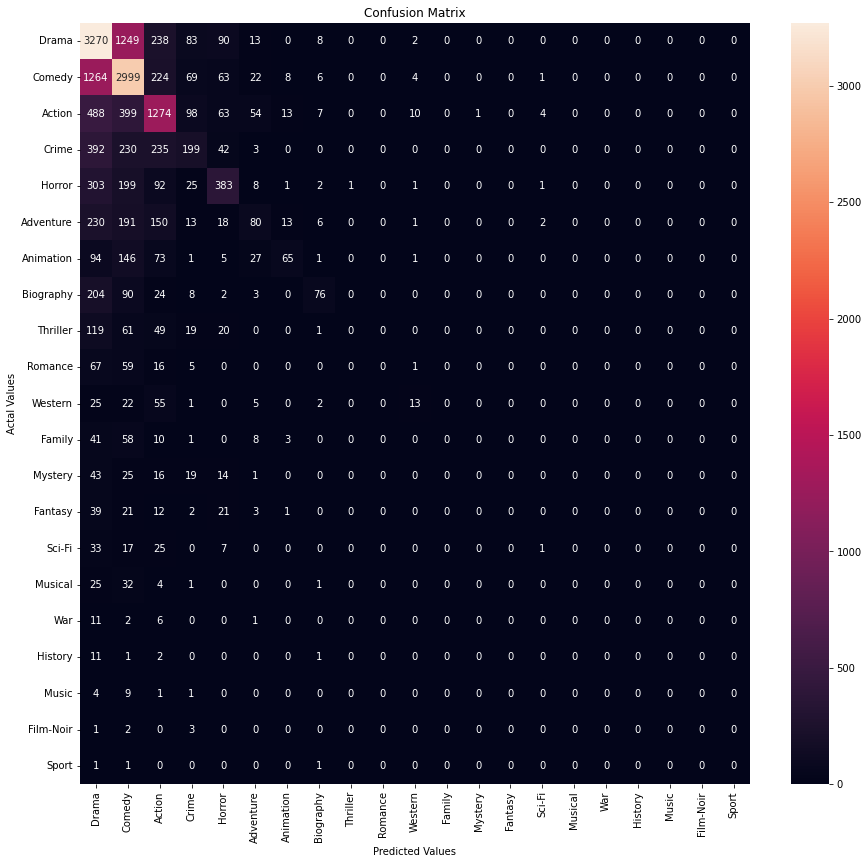

In [108]:
#Plotting the confusion matrix
plt.figure(figsize=(15,14))
sns.heatmap(cm_df, annot=True, fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [109]:
from sklearn.metrics import roc_auc_score

# Generate membership scores with .predict_proba
y_pred_probs = lr.predict_proba(X_val_tfidf)

# Calculate ROC_AUC
roc_auc = roc_auc_score(
    y_val, y_pred_probs, multi_class="ovr", average="weighted"
  )

In [110]:
roc_auc

0.8098617241299929